## **Coincident NASA remote sensing data over the Arctic ocean**
### Search and subset data by geographic bounding box

Melt ponds are an important feature of Arctic sea ice dynamics, leading to an decrease in sea ice albedo and other changes in heat balance. Many NASA Earthdata datasets produce variables including sea ice albedo, sea surface temperature, air temperature, and sea ice height, which can be used to better understand these dynamics. This notebook walks through the discovery, subsetting, and accessing of multiple data products coincident over an Arctic Ocean melt pond region, demonstrating how to obtain and harmonize coincident remote sensing data. 

As NASA Earthdata transitions to the Earthdata Cloud, it will be common for some data to exist in a traditional on-premise storage system, accessed by direct download to a local environment, while other data will have migrated to the cloud system. This need to access and customize data from both storage locations is addressed in this notebook: While one dataset's subsetting and access service utilizes the Earthdata Cloud, the data can be discovered and downloaded in the same manner as the other dataset. These Download and Service diagrams, presented in the Introduction, are highlighted in the steps below.


<p float="left">
  <img src="cloud_download.png" width="300" />
  <img src="cloud_services.png" width="300" /> 
</p>


### Learning objectives:
1. Select NASA Earthdata sea ice and sea surface temperature datasets
2. Identify data file size and availability over time and geographic bounding box
3. Subset and download data, from both Earthdata Cloud and on-premise resources, using an Application Programmatic Interface (API)
4. Plot and compare coincident data values

___

### **Explore NASA Earthdata sea ice and ocean products over a melt pond feature of interest**


We will be working with a study area just north of Greenland in the Arctic Ocean. The OpenAltimetry application provides on-the-fly visualizations of height measurements produced by ICESat-2, where interesting features can be tagged and shared, like this melt pond observation:



<img src="OpenAltimetry-study-area.png" width="800" >

Source: https://openaltimetry.org/data/icesat2/?start_date=2019-06-22&annoId=180


NASA Earthdata Search enables searching, visualization, and access to data across thousands of Earth science datasets. Additional customization services are available for select datasets, including subsetting, reformatting, and reprojection. The following search results are produced from a sea ice elevation and sea surface temperature keyword search over the region of interest:

[NASA Earthdata Search results from SST and sea ice height keyword selection](https://search.earthdata.nasa.gov/search?sb[0]=-62.8%2C81.7%2C-56.4%2C83&m=77.22181155531852!-91.2265556441681!2!0!0!0%2C2&fs10=Sea%20Ice%20Elevation&fsm0=Sea%20Ice&fst0=Cryosphere&fs21=Skin%20Sea%20Surface%20Temperature&fs11=Sea%20Surface%20Temperature&fsm1=Ocean%20Temperature&fst1=Oceans)

There are still 15 different datasets listed(!), which highlights the breadth and variety of data cataloged by NASA Earthdata Search. We are selecting two products from this list: Level 3A sea ice height data from the ATLAS instrument onboard ICESat-2 mission, and Global Skin Sea Surface Temperature from the MODIS instrument onboard Terra. 

Dataset references:

* [GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Terra satellite (GDS2)](https://doi.org/10.5067/GHMDT-2PJ19)
* [ATLAS/ICESat-2 L3A Sea Ice Height](https://doi.org/10.5067/ATLAS/ATL07.003)



___
### **Import packages**

In [24]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import numpy.ma as ma

import tutorial_helper_functions as fn

___ 

### **Earthdata Login Authentication**

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The `setup_earthdata_login_auth` function will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

Set up Earthdata Login authentication for each search, subset, and access request:

In [2]:
# Get your authentication token for searching restricted records in the CMR:
_token = fn.setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
fn.setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  amy.steiker
Password:  ·········


Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.


Username:  amy.steiker
Password:  ·········


#### Record time and area of interest 

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below

In [3]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-62.8,81.7,-56.4,83'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2019-06-22T00:00:00Z,2019-06-22T23:59:59Z'

#### Explore data availability using the Common Metadata Repository
The Common Metadata Repository (CMR) is a robust metadata system that catalogs Earth Science data and associated service metadata records. CMR supports data search and discovery through an Application Programming Interface, or API, enabling reproducible data product and data file searches using a number of helpful variables, including geographic area, keyword, and time.

General CMR API documentation: https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html



NASA Earthdata Search can be used to visualize file coverage over mulitple data sets and to access the same data you will be working with below: [insert URL with same search here]

Data sets are selected by data set IDs (e.g. ATL07). In the CMR API documentation, a data set id is referred to as a "short name". These short names are located at the top of each NSIDC data set landing page in gray above the full title. 

Start by creating a nested dictionary with each data set shortname and version, as well as shared temporal range and area of interest. Data set shortnames, or IDs, as well as version numbers, are located at the top of every NSIDC landing page.

In [4]:
search_parameters = { 
    'height': {'short_name': 'ATL07','version': '003', 'provider': 'NSIDC_ECS','bounding_box': bounding_box,'temporal': temporal},
    'sst': {'short_name': 'MODIS_T-JPL-L2P-v2019.0','version': '2019.0','provider': 'POCLOUD','bounding_box': bounding_box,'temporal': temporal},
            }

#### Discover file number and file size 

Using CMR search, determine the number of files that exist over this time and area of interest, as well as the average size and total volume of those files.

In [5]:
for k, v in search_parameters.items(): fn.search_granules(search_parameters[k], _token)

Found 2 files
The total size of all files is 461.70 MB
Found 11 files
The total size of all files is 102.69 MB


Note that subsetting, reformatting, or reprojecting can alter the size of the granules if those services are applied to your request.



### **Data Access and Subsetting**

#### Determine subsetting service options

We can also use CMR search to determine what transformation services, such as spatial subsetting, reformatting, reprojection, and resampling, are available for each data product. 

In [6]:
for k, v in search_parameters.items(): 
    print(search_parameters[k]['short_name'],":")
    fn.search_services(search_parameters[k], _token)

ATL07 :
{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False},
                              'Shapefile': [{'Format': 'ESRI'},
                                            {'Format': 'KML'},
                                            {'Format': 'GeoJSON'}]},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': True}},
 'SupportedReformattings': [{'SupportedInputFormat': 'HDF5',
                             'SupportedOutputFormats': ['ASCII',
                                                        'NETCDF-3',
                                                        'NETCDF-4',
                                                        'Shapefile']}]}
MODIS_T-JPL-L2P-v2019.0 :
{'SupportedReformattings': [{'SupportedInputFormat': 'HDF5',
                             'SupportedOutputFormats': ['NETCDF-4']},
                            {'SupportedInputFormat': 'NETCDF-4',
                             'Supported

For our purposes, even though there are several other options for spatial area input like shapefile (see previous tutorial for this!), we'll use a simple bounding box to crop our data to that area. 

### Data Access

#### Data Access from NSIDC outside of Earthdata Cloud

ATL07, along with many other products availabe at the NSIDC DAAC, can be customized through subsetting, reformatting, and/or reprojection services prior to data access. Those options are available via a custom NSIDC API. These request options can be specified in a parameter dictionary to create the API endpoint. Insert your email into the `param_dict` to receive an email notification with your data order:

In [7]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# bounding box search and subset:
param_dict = {'short_name': 'ATL07', 
              'version': '003', 
              'temporal': temporal, 
              'bounding_box': bounding_box, 
              'bbox': bounding_box, 
              'page_size': '10', 
              'request_mode': 'async',
              'email': '', }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

API_request = api_request = f'{base_url}?{param_string}'
print(API_request)

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL07&version=003&temporal=2019-06-22T00:00:00Z,2019-06-22T23:59:59Z&bounding_box=-62.8,81.7,-56.4,83&bbox=-62.8,81.7,-56.4,83&page_size=10&request_mode=async


In [8]:
fn.request_nsidc_data(API_request)

Order status URL:  https://n5eil02u.ecs.nsidc.org/egi/request/5000000928676
Job status is  processing . Trying again.
Job status is  complete
Zip download URL:  https://n5eil02u.ecs.nsidc.org/esir/5000000928676.zip
Beginning download of zipped output...
Download is complete.


#### Data Access using Earthdata Cloud services

The GHRSST MODIS data can be subsetted and accessed via [Earthdata Harmony](https://harmony.earthdata.nasa.gov/). These services are processed in the cloud, with data archived in the cloud, and outputs can be accessed by downloading to a local machine or through direct in-region access via Amazon Web Services. 

In [10]:
fn.request_harmony_data(search_parameters["sst"], _token)

Request URL https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=lat(81.7:83)&subset=lon(-62.8:-56.4)&subset=time("2019-06-22T00:00:00Z":"2019-06-22T23:59:59Z")
{'createdAt': '2020-11-24T02:28:08.505Z',
 'jobID': 'd2416155-5eba-49d3-8472-07b6cb3ecf8e',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/d2416155-5eba-49d3-8472-07b6cb3ecf8e',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'}],
 'message': 'The job is being processed',
 'progress': 0,
 'request': 'https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(81.7%3A83)&subset=lon(-62.8%3A-56.4)&subset=time(%222019-06-22T00%3A00%3A00Z%22%3A%222019-06-22T23%3A59%3A59Z%22)',
 'status': 'running',
 'updatedAt': '2020-11-24T02:28:08.505Z',
 'username': 'amy.steiker'}
Job URL https://harmony.earthdata.nasa.gov/jobs/d2416155-5eba-49d3-8472-

___ 
### **Data Plotting and Comparison** 

Read in a single file from each of our API outputs:

* MODIS_T-JPL-L2P-v2019.0: 
    * 20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc 
    
* ATL07:
    * processed_ATL07-01_20190622200154_13070301_003_02.h5
    
More description on file structures and libraries used to read the data

#### Read in MODIS_T-JPL-L2P-v2019.0

In [13]:
filepath = './20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc' # Define local filepath 

sst = xr.open_dataset(filepath)
list(sst.variables)

['lat',
 'lon',
 'sea_surface_temperature',
 'sst_dtime',
 'quality_level',
 'sses_bias',
 'sses_standard_deviation',
 'l2p_flags',
 'chlorophyll_a',
 'K_490',
 'wind_speed',
 'dt_analysis',
 'time']

#### Read in ATL07

In [33]:
atl_filepath = './Outputs/processed_ATL07-01_20190622200154_13070301_003_02.h5' # Define local filepath 

VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_height',]
}

atl07 = fn.load_icesat2_as_dataframe(atl_filepath, VARIABLES)
atl07.tail()

,beam,delta_time,height_segment_height,latitude,longitude,filename
42559,gt3l,4.647045e+07,0.591261,82.177667,-58.927473,processed_ATL07-01_20190622200154_13070301_003...
42560,gt3l,4.647045e+07,0.430999,82.177605,-58.927597,processed_ATL07-01_20190622200154_13070301_003...
42561,gt3l,4.647045e+07,0.116308,82.177523,-58.927759,processed_ATL07-01_20190622200154_13070301_003...
42562,gt3l,4.647045e+07,-0.346326,82.177312,-58.928180,processed_ATL07-01_20190622200154_13070301_003...
42563,gt3l,4.647045e+07,-0.122129,82.177207,-58.928390,processed_ATL07-01_20190622200154_13070301_003...


#### Plot Data 

More on data plotting methods...

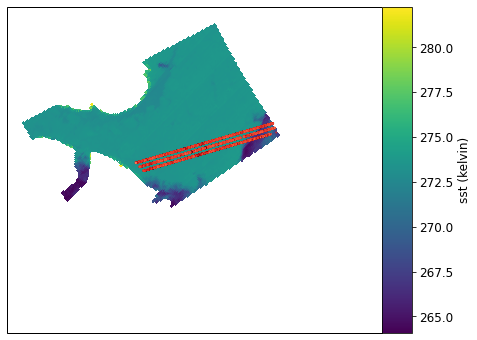

In [37]:
#Convert sst data array to masked array:
lon = ma.masked_invalid(sst['lon'])
lat = ma.masked_invalid(sst['lat'])
sst_array = ma.masked_invalid(sst['sea_surface_temperature'])

# adapted from https://bairdlangenbrunner.github.io/python-for-climate-scientists/matplotlib/pcolormesh-grid-fix.html
map_proj = cartopy.crs.NorthPolarStereo()
data_proj = cartopy.crs.PlateCarree()
#geodetic_proj = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection=map_proj)
#ax.coastlines(color='red')
sst_plot = ax.pcolor(lon,\
                      lat,\
                      sst_array[0],\
                      transform=data_proj)
ax.set_extent([-61.5,-53.5,81.5,83.5])

# add colorbar
axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x1+0,axpos.y0,0.03,axpos.height])
cbar = fig.colorbar(sst_plot, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('sst (kelvin)', fontsize=12)

height_plot = ax.scatter(atl07.longitude,\
                        atl07.latitude,\
                        c=atl07.height_segment_height,\
                        vmax=1.5,\
                        cmap='Reds',\
                        alpha=0.7,\
                        s=1,\
                        transform=data_proj)
# cbar2_ax = fig.add_axes([axpos.x1+0,axpos.y0,0.03,axpos.height])
# cbar2 = fig.colorbar(height_plot,cax=cbar2_ax)
# cbar2.ax.tick_params(labelsize=12)
# cbar2.set_label('ATL07 Height (m)',fontsize=12)

In [38]:
# filepath = './20190622192501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc' # Define local filepath 

# sst = xr.open_dataset(filepath)
# list(sst.variables)

# da = xr.DataArray(sst['sea_surface_temperature'], dims=['x', 'y'], coords={'lon': (['x', 'y'], lon), 'lat': (['x', 'y'], lat)})

# # basic plot of atl07
# plt.subplots(figsize=(10,5)) # set size
# #plt.pcolormesh(sst_array[0], cmap='viridis')
# #plt.colorbar(label='SST (kelvin)')
# plt.scatter(atl07.longitude, atl07.latitude,
#           c=atl07.height_segment_height, vmax=1.5,
#           cmap='Reds', alpha=0.6, s=1)  
# plt.colorbar(label='ATL07 Height (m)')
# plt.show()

# #basic plot of sst
# plt.subplots(figsize=(10,5)) # set size
# sst['sea_surface_temperature'].plot(cmap='viridis');